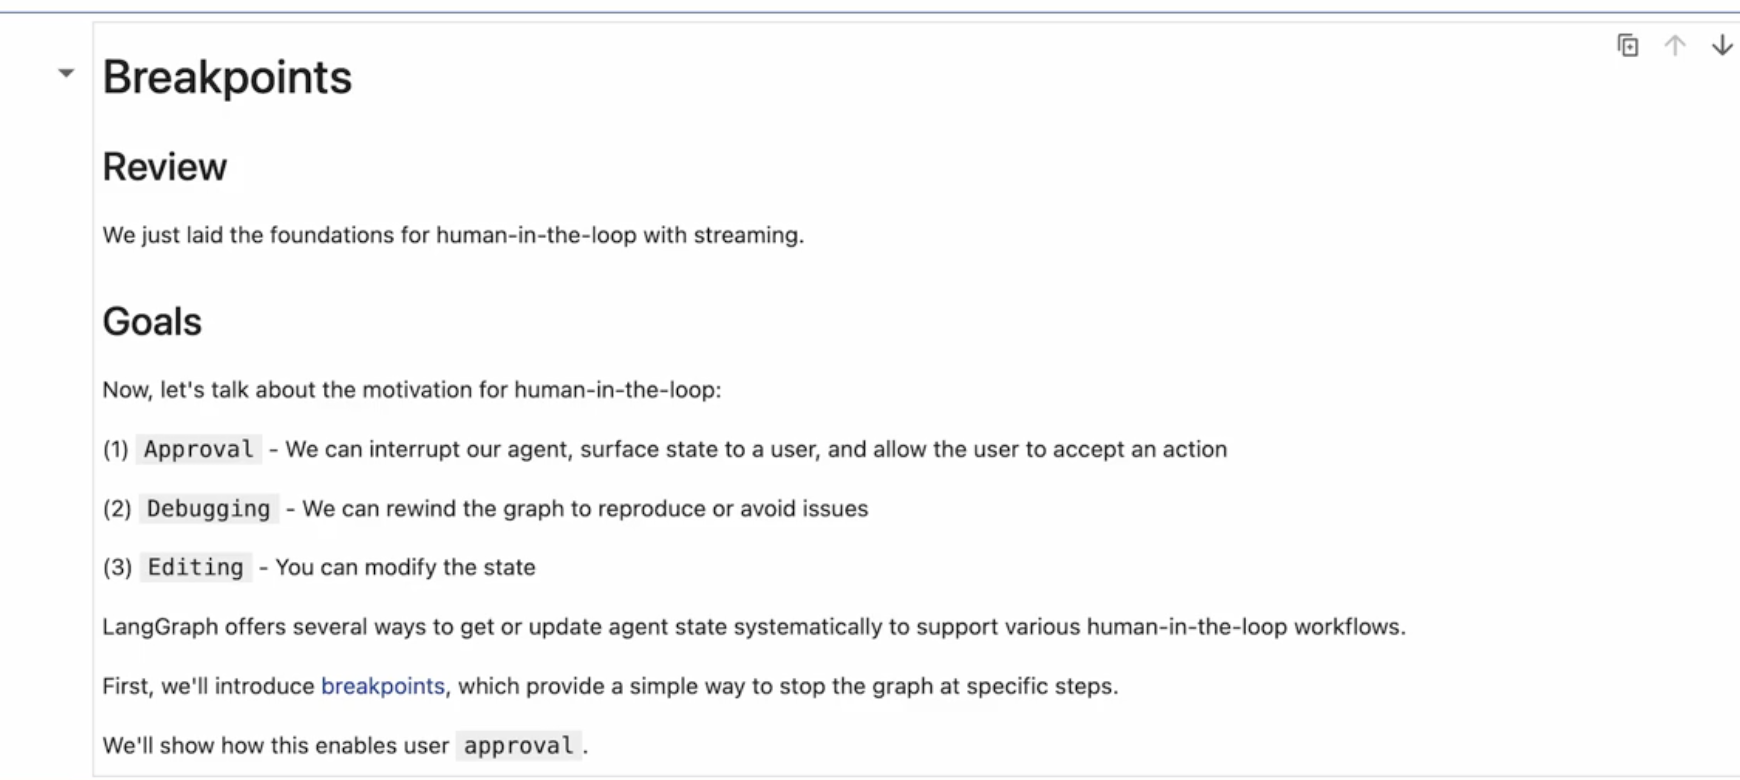

1) Breakpoints for human approval
2) Debugging
3) Editing

#### Breakpoints for human approval

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash', temperature=1.0, google_api_key = GOOGLE_API_KEY)

/opt/anaconda3/envs/langchainAcademy/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [24]:
def multiply(a,b):
    ''' Multiple two numbers
    Agrs
    a: first int
    b: second int
    '''
    return a*b

def divide(a, b):
    ''' Divide two numbers
    Args
    a: first int
    b: second int
    '''
    return a/b

def add(a,b):
    ''' Add two numbers
    Args
    a: first int
    b: second int
    '''
    return a+b

tools = [multiply, add, divide]
llm_with_tools = llm.bind_tools(tools)

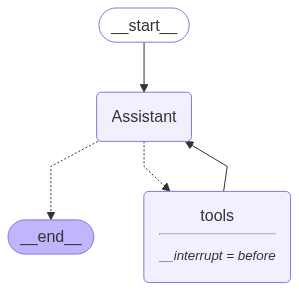

In [25]:
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage

class MessagesState(TypedDict):
    messages: Annotated[list[str], add_messages]
    
sys_message = SystemMessage(content = 'You are a helpful assistant tasked with performing arithmetic on a set of inputs')

def llm_call(state: MessagesState):
    return {'messages': [llm_with_tools.invoke([sys_message] +state['messages'])]}
    
builder = StateGraph(MessagesState)
builder.add_node('Assistant', llm_call)
builder.add_node('tools', ToolNode(tools))

# LOGIC
builder.add_edge(START, 'Assistant')
builder.add_conditional_edges('Assistant', tools_condition)
builder.add_edge('tools', 'Assistant')

memory = MemorySaver()

graph = builder.compile(interrupt_before = ['tools'], checkpointer = memory)
graph

In [27]:
from langchain_core.messages import HumanMessage, AnyMessage, RemoveMessage
initial_input = {'messages': ['what is 2 times 39']}

thread = {'configurable': {'thread_id':5}}

for event in graph.stream(initial_input, thread, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what is 2 times 39
================================== Ai Message ==================================
Tool Calls:
  multiply (bc285072-26cc-4dc4-8c25-6f361006c332)
 Call ID: bc285072-26cc-4dc4-8c25-6f361006c332
  Args:
    a: 2.0
    b: 39.0


In [31]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='what is 2 times 39', additional_kwargs={}, response_metadata={}, id='02dd7ff8-d270-404d-9b2e-b0df7df7524f'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 39.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--94e63ae0-dab5-4c4e-81a8-ba81f2f15c50-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 39.0}, 'id': 'bc285072-26cc-4dc4-8c25-6f361006c332', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_tokens': 5, 'total_tokens': 91, 'input_token_details': {'cache_read': 0}})]}, next=('tools',), config={'configurable': {'thread_id': '5', 'checkpoint_ns': '', 'checkpoint_id': '1f0465f1-ea30-6d3a-8001-915a799f6bc0'}}, metadata={'source': 'loop', 'writes': {'Assistant': {'messages': [AIMessage(content='', additional_kwargs={

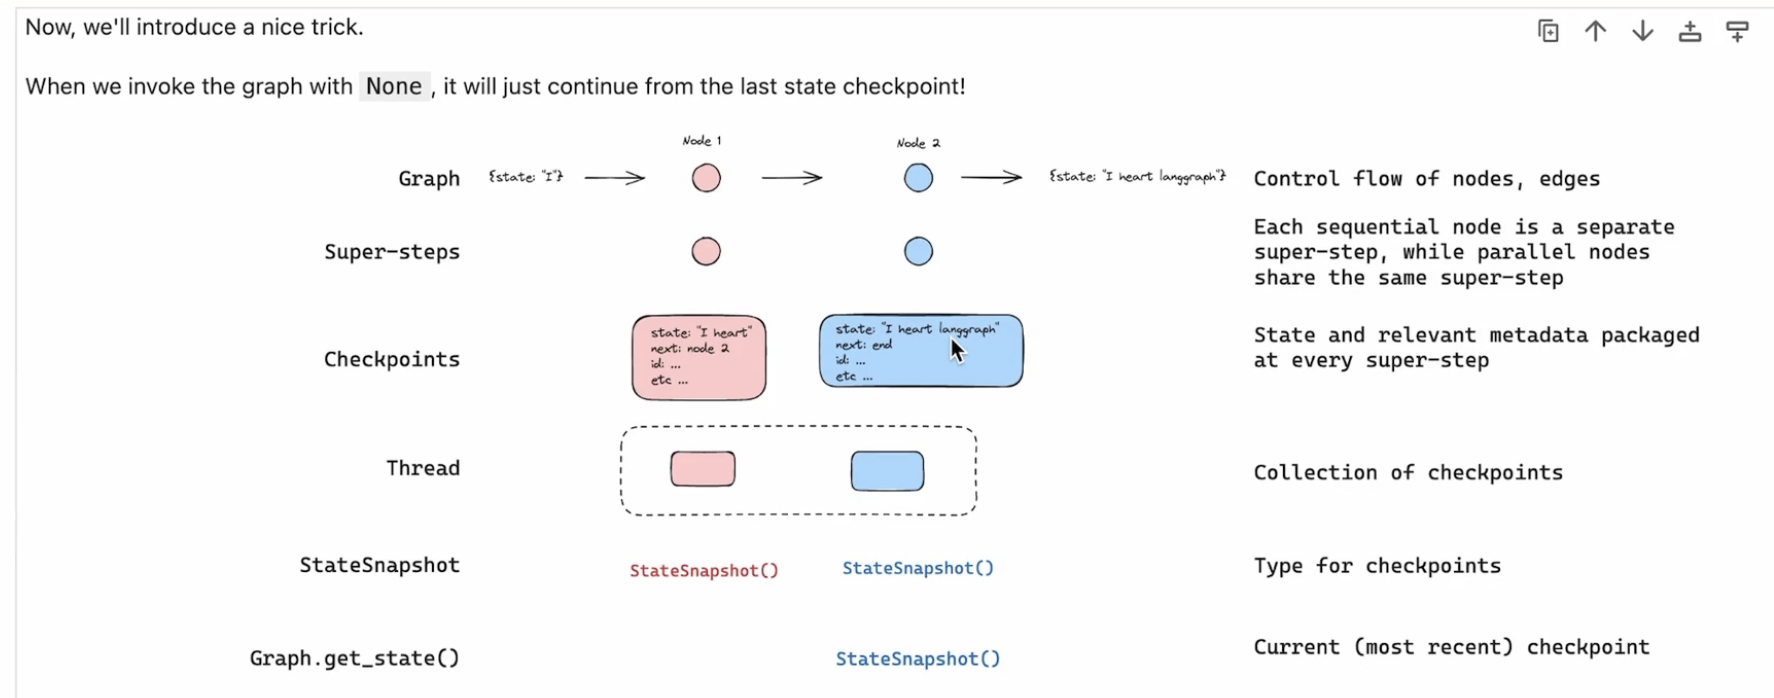

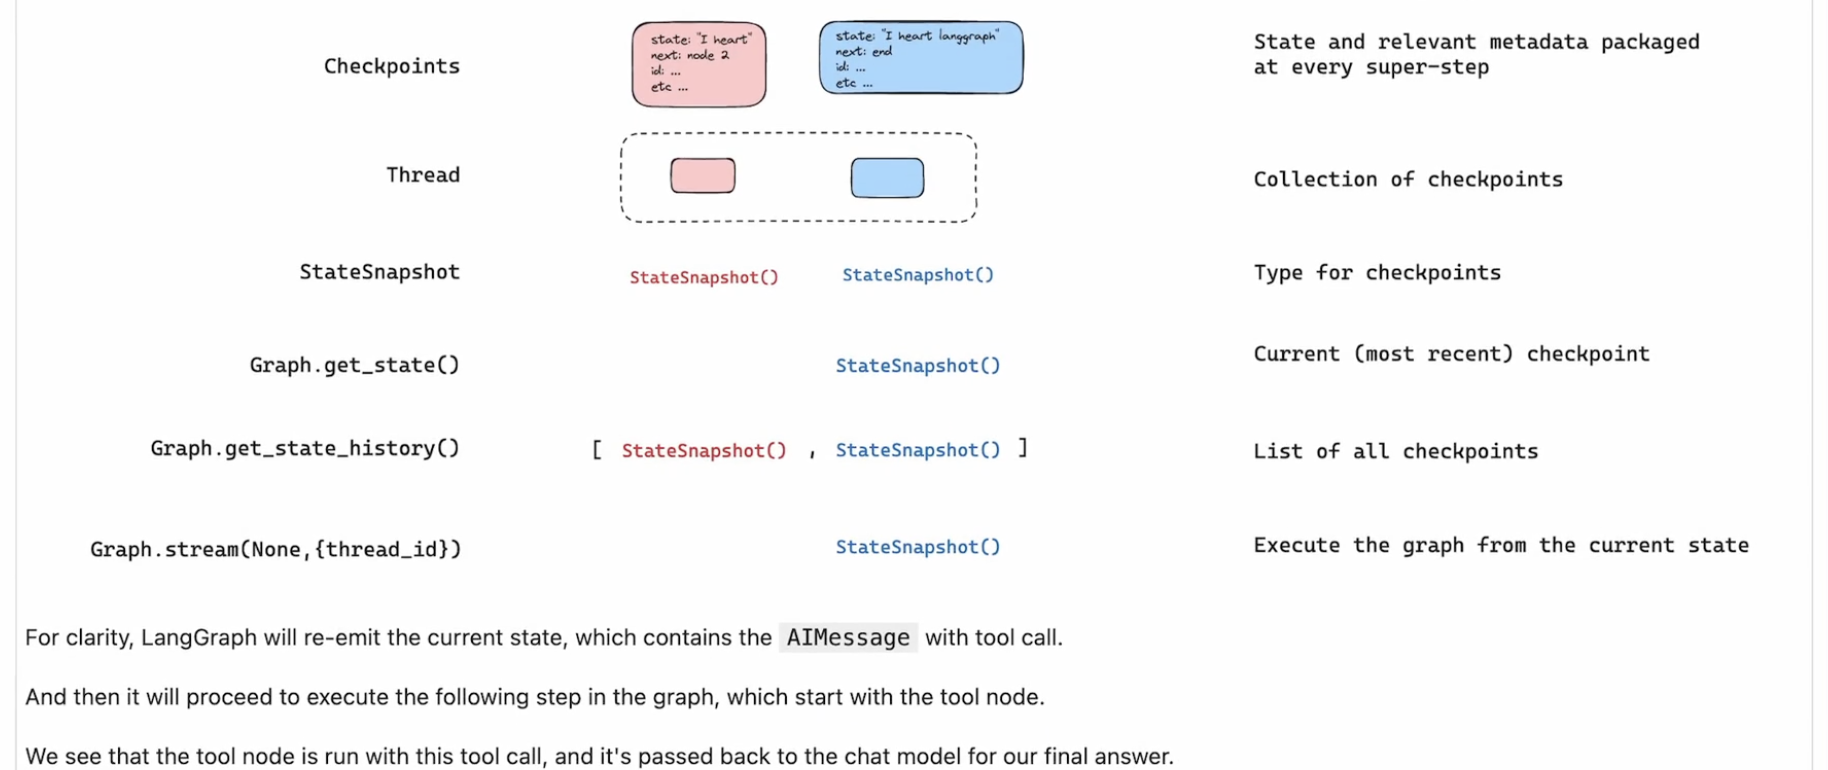

CONTINUE THE EXECUTION USING GRAPH.stream(None, {thread_id})

In [32]:
for event in graph.stream(None, thread, stream_mode = 'values' ):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (bc285072-26cc-4dc4-8c25-6f361006c332)
 Call ID: bc285072-26cc-4dc4-8c25-6f361006c332
  Args:
    a: 2.0
    b: 39.0
================================= Tool Message =================================
Name: multiply

78.0
================================== Ai Message ==================================

2 times 39 is 78.
